In [1]:
from train_util_escnn import *
import torch
import time

device = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE =40# 40 is also fine

LEARNING_RATE = 1e-4

EPOCHS = 100

MODEL_SAVE_PATH = "./models/model_unet1.pth"

2025-02-12 00:21:28.294623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-12 00:21:28.314657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-12 00:21:28.314688: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 00:21:29.092981: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
xdata, ydata, test_xdata, test_ydata = get_data(None, ['train/1'], 'data')

train_dataset = MF_Dataset(xdata, ydata)
test_dataset = MF_Dataset(test_xdata, test_ydata)

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)

train_dataloader = DataLoader(dataset=train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
val_dataloader   = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader  = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True)


model = steerable_u_net(in_channels=1, feat=8).to(device)


In [3]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
criterion = torch.nn.MSELoss()

In [4]:
history = {'train_loss': [], 'val_loss': []}
best_val_loss = None

for epoch in range(EPOCHS):
    tic = time.time()
    model.train()
    train_running_loss = 0
    for idx, xydata in enumerate((train_dataloader)):
        _xdata = xydata[0].float().to(device).squeeze(dim=1)
        _ydata = xydata[1].float().to(device)

        y_pred = model(_xdata) 
        optimizer.zero_grad()

        loss = criterion(y_pred, _ydata)
        train_running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    
    scheduler.step()
    
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for idx, xydata in enumerate(val_dataloader):
            _xdata = xydata[0].float().to(device).squeeze(dim=1)
            _ydata = xydata[1].float().to(device)

            y_pred = model(_xdata)
            loss = criterion(y_pred, _ydata)

            val_running_loss += loss.item()
        val_loss = val_running_loss / (idx + 1)

    elapse = time.time() - tic

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    if best_val_loss is None or val_loss < best_val_loss:
        torch.save(model.state_dict(), MODEL_SAVE_PATH) # official recommended
        best_val_loss = val_loss
        
    if epoch % 10 == 0:
        print(f"Train Loss EPOCH {(epoch+1):6d}: {train_loss:6.4e} | Valid Loss EPOCH {(epoch+1):6d}: {val_loss:6.4e} | time: {elapse: 6.4f}")

Train Loss EPOCH      1: 1.5396e+00 | Valid Loss EPOCH      1: 1.5186e+00 | time:  1.8770
Train Loss EPOCH     11: 1.7790e-01 | Valid Loss EPOCH     11: 1.7136e-01 | time:  1.6504
Train Loss EPOCH     21: 1.3027e-01 | Valid Loss EPOCH     21: 1.2956e-01 | time:  1.6642
Train Loss EPOCH     31: 1.0661e-01 | Valid Loss EPOCH     31: 1.0815e-01 | time:  1.6767
Train Loss EPOCH     41: 9.6884e-02 | Valid Loss EPOCH     41: 9.9657e-02 | time:  1.6724
Train Loss EPOCH     51: 9.1208e-02 | Valid Loss EPOCH     51: 9.5242e-02 | time:  1.6876
Train Loss EPOCH     61: 8.7074e-02 | Valid Loss EPOCH     61: 9.1970e-02 | time:  1.6780
Train Loss EPOCH     71: 8.4102e-02 | Valid Loss EPOCH     71: 9.0196e-02 | time:  1.6801
Train Loss EPOCH     81: 8.1959e-02 | Valid Loss EPOCH     81: 8.8951e-02 | time:  1.6834
Train Loss EPOCH     91: 8.0222e-02 | Valid Loss EPOCH     91: 8.8115e-02 | time:  1.6798


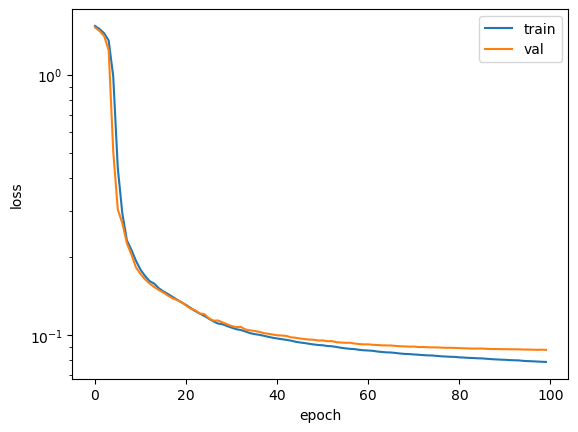

In [5]:
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log',base=10) 
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [7]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH), strict=True)
model.eval()

test_running_loss = 0

with torch.no_grad():

    for idx, xydata in enumerate(test_dataloader):
        _xdata = xydata[0].float().to(device).squeeze(dim=1)
        _ydata = xydata[1].float().to(device)

        y_pred = model(_xdata)
        loss = criterion(y_pred, _ydata)

        test_running_loss += loss.item()
        test_loss = test_running_loss / (idx + 1)

    print(test_loss)

0.08353704959154129


In [9]:
gen_data('out/1', ['train/1'], None, 'data', model)

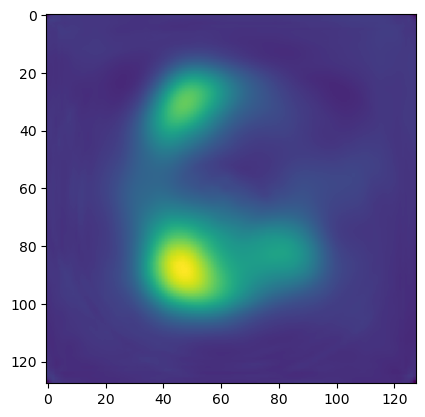

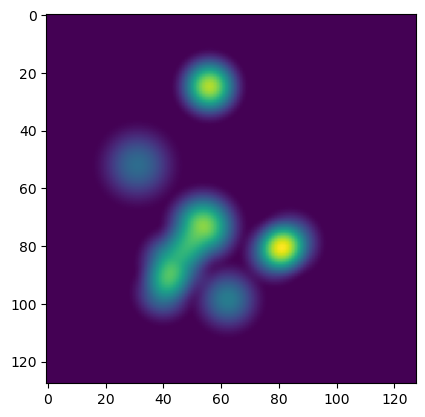

In [10]:
id = 2
img = scipy.io.loadmat(os.path.join('out/1', 'train_'+str(id) +'.mat'))['value']
plt.imshow(img)
plt.show()
img = scipy.io.loadmat(os.path.join('data', 'data_'+str(id) +'.mat'))['value']
plt.imshow(img)
plt.show()